# Nowcast Library Pipeline - A Tutorial

The Nowcast Library Pipeline is intended as a holistic yet modular system for processing and synchronizing data, fitting models to it, and evaluating these models.

This notebook will provide users with an example of how one may use the library, along with a description of the available functionality.

## Preliminary Notes 

The pipeline is primarily intended to be used via the command line. As such this notebook will mostly make calls to the command line. In Jupyter Notebooks, this is done by adding an exclamation mark prefix to the prompt, as such:

---

In [1]:
!nowcastlib -h

usage: nowcastlib [-h] [-v]
                  {triangulate,preprocess,sync,postprocess,datapipe} ...

positional arguments:
  {triangulate,preprocess,sync,postprocess,datapipe}
                        available commands
    triangulate         Run `nowcastlib triangulate -h` for further help
    preprocess          Run `nowcastlib preprocess -h` for further help
    sync                Run `nowcastlib sync -h` for further help
    postprocess         Run `nowcastlib postprocess -h` for further help
    datapipe            Run `nowcastlib datapipe -h` for further help

optional arguments:
  -h, --help            show this help message and exit
  -v, --verbose         increase verbosity level from INFO to DEBUG


---
Users should therefore take note not to copy the exclamation mark when copying with the intention of pasting example prompts into their own terminal.

## Configuration

If we ask for help with any of the pipeline cli commands, we will notice that the pipeline only takes a single argument to run:

---

In [2]:
!nowcastlib datapipe -h

usage: nowcastlib datapipe [-h] -c CONFIG

Run the data-wrangling pipeline step: Preprocessing, Synchronization and
Postprocessing

optional arguments:
  -h, --help            show this help message and exit
  -c CONFIG, --config CONFIG
                        path to JSON file following the DataSet format. See
                        docs for available fields


---

Namely `-c` or `--config`, the path to a JSON file containing the desired configuration for our pipeline command.

The "schema" for this configuration file can be inferred from the custom classes or "structs" defined in the nowcastlib.pipeline.structs submodule, with documentation available [here](https://www.giuliostarace.com/nowcastlib/pipeline/structs). 

Any JSON configuration will essentially be a representation of an instance of the `DataSet` class, with additional sub-classes (for more granular configuration) defined within.

## Example Config

Let's explore the available configuration options by gradually building a `DataSet` JSON object. If we look at the `DataSet` class we see that we can represent a (very bare) `DataSet` instance with the following JSON:

```JSON
{
    "data_sources":[],
    "sync_options":null,
    "split_options": null,
    "generated_fields": null
}
```

### DataSources

Any `DataSet` instance will need to list the `DataSource`s comprising it. This is specified via the `data_sources` key. The other keys are for additional 
configuration, which the user may even omit (omitting will default them to null, or `NoneType` as referred to in the documentation). We will get to these later. 

Let's start by specifying two data sources, La Silla DIMM and La Silla Meteo.

```JSON
{
    "data_sources": [
        {
            "name": "lso_dimm",
            "path": "data/LSO/lasilla_dimm.csv",
            "fields": [],
            "comment_format": "#",
        },
        {
            "name": "lso_meteo",
            "path": "data/LSO/lasilla_meteo.csv",
            "fields": [],
            "comment_format": "#",
        },
    ],
}
```

### DataFields

For each `DataSource`, we then also have to specify what fields (columns) we are interested in, and what to do with them. We do this by listing `RawField` objects under the `fields` key of each `DataSource`:

```JSON
{
   "data_sources":[
      {
         "name":"lso_dimm",
         "path":"data/LSO/lasilla_dimm.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"DIMM Seeing [arcsec]"
            }
         ],
         "comment_format":"#"
      },
      {
         "name":"lso_meteo",
         "path":"data/LSO/lasilla_meteo.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"Wind Speed at 10m [m/s]"
            },
            {
               "field_name":"Wind Direction at 10m [deg]"
            }
         ],
         "comment_format":"#"
      }
   ]
}
```

### Preprocessing

For the moment, we are simply specifying the field name in the csv file, and whether the field is the date to be used as the index.

We can now start specifying how we wish to preprocess each `RawField` entry with the `preprocessing_options` key. 

For conciseness, we will use the "DIMM Seeing [arcsec]" field as an example and omit adding further configuration to the other fields, but in practice one may very well choose to process all fields.

Omitting further configuration is equivalent to setting the respective keys their default, which is often `null` (or `None` in Python). In general, when keys are `null` or omitted, this signals to the pipeline that the user is not interested in running the relevant processing steps for that field. Users should check the documentation about specific default behavior of each key.

```JSON
{
   "data_sources":[
      {
         "name":"lso_dimm",
         "path":"data/LSO/lasilla_dimm.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"DIMM Seeing [arcsec]",
               "preprocessing_options":{
                  "overwrite":false,
                  "outlier_options":{
                     "lower":0,
                     "upper":5,
                     "quantile_based":false
                  }
               }
            }
         ],
         "comment_format":"#"
      },
      {
         "name":"lso_meteo",
         "path":"data/LSO/lasilla_meteo.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"Wind Speed at 10m [m/s]"
            },
            {
               "field_name":"Wind Direction at 10m [deg]"
            }
         ],
         "comment_format":"#"
      }
   ]
}
```

We have added some preprocessing options to the "DIMM Seeing [arcsec]" field. 

- We set `overwrite` to `false` (although this is the default). The original column will be maintained in the data and a new column of the same name prefixed with "processed_" will be created. If we had set `overwrite` to `true`, the original column would have been overwritten.
- With the `outlier_options` key we are filtering "outliers" by specifying the allowed range of values that the field may have. We are doing so in absolute terms since we have set `quantile_based` to `false`. Alternatively we may have decided that we only wanted to keep the bottom 99.9999% of the data, in which case we would have set `quantile_based` to `true` and `upper` to `0.999999`.
- We do not handle any periodicity with `periodic_options` because our quantity is not periodic in nature. Had we been dealing with for example Wind Direction, we may have wanted our values to be limited to the range `[0, 360[`, such that values of `361` would be mapped to `1` for example. An example `periodic_options` configuration for the above may have looked like:
    ```JSON
    {
    "period_length":360
    }
    ```
- We do not perform any unit conversion with `conversion_options` since we are happy with our current units. An example `conversion_options` configuration for converting from miles per hour to meters per second may have looked like:
    ```JSON
    {
        "key":"mph2ms"
    }
    ```
- We do not perform any smoothing by omitting the `smoothing_options` key. This is simply because in this notebook this will be peformed in postprocessing. Users may decide to perform smoothing in preprocessing although this is generally not suggested.

#### Preprocessing Serialization

The pipeline can also be used to perform only data preprocessing. In this case the user will probably wish to serialize (save to disk) the preprocessing results. This is done by configuring the `preprocessing_output` key for any `DataSource` whose preprocessing results we wish to serialize. 

Since we are only preprocessing the "lso_dimm" data source, let's go ahead and serialize only that:

```JSON
{
   "data_sources":[
      {
         "name":"lso_dimm",
         "path":"data/LSO/lasilla_dimm.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"DIMM Seeing [arcsec]",
               "preprocessing_options":{
                  "overwrite":false,
                  "outlier_options":{
                     "lower":0,
                     "upper":5,
                     "quantile_based":false
                  }
               }
            }
         ],
         "comment_format":"#",
         "preprocessing_output":{
            "output_format":"csv",
            "output_path":"output/example_datapipe/preproc_lso_dimm.csv"
         }
      },
      {
         "name":"lso_meteo",
         "path":"data/LSO/lasilla_meteo.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"Wind Speed at 10m [m/s]"
            },
            {
               "field_name":"Wind Direction at 10m [deg]"
            }
         ],
         "comment_format":"#"
      }
   ]
}
```

Running preprocessing with the above config should therefore result in a csv file containing the processed "lso_dimm" data.

#### Preprocessing Example run

Let's save the above config to the file `tutorial_pipeline_preprocess.json` and run a preprocessing pipeline. We will use the `-v` flag for additional verbosity.

---

In [3]:
!nowcastlib -v preprocess -c tutorial_pipeline_preprocess.json

2021-08-18 18:03:13,142 - INFO - Preprocessing dataset...
2021-08-18 18:03:13,142 - DEBUG - Preprocessing lso_dimm...
2021-08-18 18:03:13,142 - DEBUG - Reading file...
2021-08-18 18:03:14,491 - DEBUG - Processing field Date time of lso_dimm...
2021-08-18 18:03:14,491 - DEBUG - Processing field DIMM Seeing [arcsec] of lso_dimm...
2021-08-18 18:03:14,524 - DEBUG - Dropping outliers...
2021-08-18 18:03:14,683 - DEBUG - Dropping NaNs...
2021-08-18 18:03:14,787 - DEBUG - Serializing preprocessing output...
2021-08-18 18:03:20,938 - DEBUG - Preprocessing lso_meteo...
2021-08-18 18:03:20,938 - DEBUG - Reading file...
2021-08-18 18:03:29,901 - DEBUG - Processing field Date time of lso_meteo...
2021-08-18 18:03:29,901 - DEBUG - Processing field Wind Speed at 10m [m/s] of lso_meteo...
2021-08-18 18:03:29,901 - DEBUG - Processing field Wind Direction at 10m [deg] of lso_meteo...
2021-08-18 18:03:29,901 - DEBUG - Dropping NaNs...
2021-08-18 18:03:30,041 - INFO - Dataset preprocessing complete.


---

As we can see, the pipeline correctly preprocessed the "lso_dimm" DataSource as configured, dropping outliers and serializing the resulting output.

Let's read the serialized output and check it.

In [4]:
import pandas as pd

In [5]:
preproc_lso_dimm = pd.read_csv(
    "output/example_datapipe/preproc_lso_dimm.csv",
    parse_dates=True,
    index_col="Date time",
)

In [6]:
preproc_lso_dimm

,DIMM Seeing [arcsec],processed_DIMM Seeing [arcsec]
Date time,,
2005-04-19 00:26:20,2.03,2.03
2005-04-19 00:27:20,2.12,2.12
2005-04-19 00:28:20,3.13,3.13
2005-04-19 00:29:20,2.47,2.47
2005-04-19 00:30:20,2.73,2.73
...,...,...
2021-03-28 23:30:37,1.25,1.25
2021-03-28 23:31:37,1.41,1.41
2021-03-28 23:32:37,1.30,1.30


The serialization was successful. We can also see that the overwriting config was also successfully parsed given the creation of the new column. Finally we can check that our outlier configuration was respected by checking the statistics of our processed column:

In [7]:
preproc_lso_dimm["processed_DIMM Seeing [arcsec]"].describe()

count    1.256461e+06
mean     1.027188e+00
std      4.197804e-01
min      0.000000e+00
25%      7.400000e-01
50%      9.400000e-01
75%      1.220000e+00
max      4.990000e+00
Name: processed_DIMM Seeing [arcsec], dtype: float64

<AxesSubplot:>

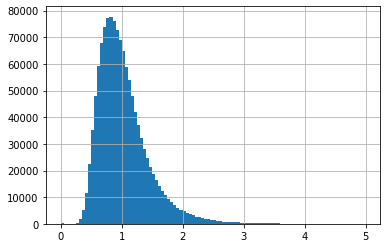

In [8]:
preproc_lso_dimm["processed_DIMM Seeing [arcsec]"].hist(bins=100)

As we can see, the data outside the range `[0, 5]` has been removed, as configured.

### Synchronization

Since we have specified more than one `DataSource` in our configuration, we can also perform _synchronization_. This is the process of aligning two or more `DataSource`s in time, matching them to a single sample-rate and only keeping chunks of data where there is complete overlap across all `DataSource`s.

To synchronize our data we need to configure the `sync_options` key of our JSON configuration at the top level:

```JSON
{
   "sync_options":{
      "sample_spacing":60,
      "chunk_options":{
         "max_gap_size":600,
         "min_chunk_size":3600
      },
      "diagnostic_plots":false
   },
   "data_sources":[
      {
         "name":"lso_dimm",
         "path":"data/LSO/lasilla_dimm.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"DIMM Seeing [arcsec]",
               "preprocessing_options":{
                  "overwrite":false,
                  "outlier_options":{
                     "lower":0,
                     "upper":5,
                     "quantile_based":false
                  }
               }
            }
         ],
         "comment_format":"#",
         "preprocessing_output":{
            "output_format":"csv",
            "output_path":"output/example_datapipe/preproc_lso_dimm.csv"
         }
      },
      {
         "name":"lso_meteo",
         "path":"data/LSO/lasilla_meteo.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"Wind Speed at 10m [m/s]"
            },
            {
               "field_name":"Wind Direction at 10m [deg]"
            }
         ],
         "comment_format":"#"
      }
   ]
}
```

The contents of the `sync_options` key is a JSON representation of a `SyncOptions` struct.

- Our `DataSource`s may have different sample rates, and as such need to be
  resampled to the same sample rate to facilitate synchronization. We specify
  this 'target' sample rate by setting the `sample_spacing` option. Here we
  have set it to 60 seconds.
- Setting `diagnostic_plots` to `true` will have the pipeline prompt the user
  to confirm their selected sample spacing after viewing a plot of the
  distributions of sample spacings of each `DataSource`. Because we are
  running the pipeline as a terminal command from within Jupyter, interactive
  plots cannot be shown, and as such it is set to `false`.
- Because synchronization can often results in "chunks", contiguous portions
  of data delimited by `NaN` gaps, the user is also required to specify
  `chunk_options`:
    - There may be instances where the gaps between data points are
      sufficiently small to be imputed with linear interpolation. The
      `max_gap_size` sets the upper limit on these small gaps. In our example,
      any gap smaller than 10 minutes (600 seconds) will be imputed via linear
      interpolation
   -  Certain chunks may be too small to be considered. In this case the user
      may wish to ignore them. The lower limit for a chunk size can therefore
      be set with `min_chunk_size`. In our example, any chunk shorter than 1
      hour (3600 seconds) will be ignored. 

#### Synchronization Example Run 1

At this point, we may run a synchronization process. However, with the current configuration, this will also run preprocessing on our `lso_dimm` `DataSource`. Let's save the JSON above to the file `tutorial_pipeline_sync_with_preprocess.json` and have a look. We once again use the `-v` flag for extra verbosity.

---

In [11]:
!nowcastlib -v sync -c tutorial_pipeline_sync_with_preprocess.json

2021-08-18 18:07:45,060 - INFO - Preprocessing dataset...
2021-08-18 18:07:45,060 - DEBUG - Preprocessing lso_dimm...
2021-08-18 18:07:45,060 - DEBUG - Reading file...
2021-08-18 18:07:46,436 - DEBUG - Processing field Date time of lso_dimm...
2021-08-18 18:07:46,436 - DEBUG - Processing field DIMM Seeing [arcsec] of lso_dimm...
2021-08-18 18:07:46,468 - DEBUG - Dropping outliers...
2021-08-18 18:07:46,592 - DEBUG - Dropping NaNs...
2021-08-18 18:07:46,648 - DEBUG - Serializing preprocessing output...
2021-08-18 18:07:52,145 - DEBUG - Preprocessing lso_meteo...
2021-08-18 18:07:52,145 - DEBUG - Reading file...
2021-08-18 18:08:00,463 - DEBUG - Processing field Date time of lso_meteo...
2021-08-18 18:08:00,463 - DEBUG - Processing field Wind Speed at 10m [m/s] of lso_meteo...
2021-08-18 18:08:00,463 - DEBUG - Processing field Wind Direction at 10m [deg] of lso_meteo...
2021-08-18 18:08:00,463 - DEBUG - Dropping NaNs...
2021-08-18 18:08:00,611 - INFO - Dataset preprocessing complete.
202

---

As we can see, both preprocessing and synchronization were performed. There was also no serialization of our synchronization output, so that is not of much use to us.

#### Synchronization Example Run 2

To avoid preprocessing, we simply need to remove any preprocessing configuration from our config file. 

```JSON
{
   "sync_options":{
      "sample_spacing":60,
      "chunk_options":{
         "max_gap_size":600,
         "min_chunk_size":3600
      },
      "diagnostic_plots":false
   },
   "data_sources":[
      {
         "name":"lso_dimm",
         "path":"data/LSO/lasilla_dimm.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"DIMM Seeing [arcsec]"
            }
         ],
         "comment_format":"#"
      },
      {
         "name":"lso_meteo",
         "path":"data/LSO/lasilla_meteo.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"Wind Speed at 10m [m/s]"
            },
            {
               "field_name":"Wind Direction at 10m [deg]"
            }
         ],
         "comment_format":"#"
      }
   ]
}
```

The output of our synchronization process is a sparse pandas dataframe with the aligned data and a numpy array of shape (-1, 2) with the start and end indices of each chunk. We can serialize these objects using the `data_output` and `chunks_output` keys respectively, which both consist in a `SerializationOptions` struct.

```JSON
{
   "sync_options":{
      "sample_spacing":60,
      "chunk_options":{
         "max_gap_size":600,
         "min_chunk_size":3600
      },
      "diagnostic_plots":false,
      "data_output":{
         "output_format":"pickle",
         "output_path":"output/example_datapipe/synced_df.pkl"
      },
      "chunks_output":{
         "output_format":"npy",
         "output_path":"output/example_datapipe/chunk_locs.npy"
      }
   },
   "data_sources":[
      {
         "name":"lso_dimm",
         "path":"data/LSO/lasilla_dimm.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"DIMM Seeing [arcsec]"
            }
         ],
         "comment_format":"#"
      },
      {
         "name":"lso_meteo",
         "path":"data/LSO/lasilla_meteo.csv",
         "fields":[
            {
               "field_name":"Date time",
               "is_date":true
            },
            {
               "field_name":"Wind Speed at 10m [m/s]"
            },
            {
               "field_name":"Wind Direction at 10m [deg]"
            }
         ],
         "comment_format":"#"
      }
   ]
}
```

Now that we're all set, let's save the JSON above to the file `tutorial_pipeline_sync.json` and try again:

---

In [14]:
!nowcastlib -v sync -c tutorial_pipeline_sync.json

2021-08-18 18:34:31,875 - INFO - Preprocessing dataset...
2021-08-18 18:34:31,875 - DEBUG - Preprocessing lso_dimm...
2021-08-18 18:34:31,875 - DEBUG - Reading file...
2021-08-18 18:34:33,274 - DEBUG - Processing field Date time of lso_dimm...
2021-08-18 18:34:33,274 - DEBUG - Processing field DIMM Seeing [arcsec] of lso_dimm...
2021-08-18 18:34:33,274 - DEBUG - Dropping NaNs...
2021-08-18 18:34:33,299 - DEBUG - Preprocessing lso_meteo...
2021-08-18 18:34:33,299 - DEBUG - Reading file...
2021-08-18 18:34:41,873 - DEBUG - Processing field Date time of lso_meteo...
2021-08-18 18:34:41,873 - DEBUG - Processing field Wind Speed at 10m [m/s] of lso_meteo...
2021-08-18 18:34:41,873 - DEBUG - Processing field Wind Direction at 10m [deg] of lso_meteo...
2021-08-18 18:34:41,873 - DEBUG - Dropping NaNs...
2021-08-18 18:34:42,014 - INFO - Dataset preprocessing complete.
2021-08-18 18:34:42,015 - INFO - Synchronizing dataset...
2021-08-18 18:34:42,015 - DEBUG - Resampling DataSource 1 of 2...
2021

---

As we can see from the logs, "preprocessing" here simply consisted in reading the raw data and dropping NaNs. Synchronization was performed once again but this time we have serialized files that we can check.

In [15]:
synced_df = pd.read_pickle("output/example_datapipe/synced_df.pkl")

In [16]:
synced_df

,DIMM Seeing [arcsec],Wind Direction at 10m [deg],Wind Speed at 10m [m/s]
2005-04-19 00:26:00,NaN,NaN,NaN
2005-04-19 00:27:00,NaN,NaN,NaN
2005-04-19 00:28:00,NaN,NaN,NaN
2005-04-19 00:29:00,NaN,NaN,NaN
2005-04-19 00:30:00,NaN,NaN,NaN
...,...,...,...
2021-03-29 01:01:00,NaN,NaN,NaN
2021-03-29 01:02:00,NaN,NaN,NaN
2021-03-29 01:03:00,NaN,NaN,NaN
2021-03-29 01:04:00,NaN,NaN,NaN


In [17]:
import numpy as np

In [18]:
chunk_locs = np.load("output/example_datapipe/chunk_locs.npy")

In [19]:
chunk_locs

array([[     52,     143],
       [    170,     507],
       [   1560,    1932],
       ...,
       [8382631, 8382758],
       [8383719, 8383858],
       [8384028, 8384186]])

We can now for example break our `synced_df` into an array of non-sparse dataframes using `nowcastlib.datasets`, with our pre-computed `chunk_locs` to speed up the process.

In [20]:
from nowcastlib.datasets import make_chunks

In [21]:
chunks = make_chunks(synced_df, chunk_locs)

In [30]:
# showing an arbitrary chunk
chunks[30]

,DIMM Seeing [arcsec],Wind Direction at 10m [deg],Wind Speed at 10m [m/s]
2005-05-13 22:30:00,2.080,14.0,1.2
2005-05-13 22:31:00,2.180,14.0,1.2
2005-05-13 22:32:00,2.370,14.0,1.4
2005-05-13 22:33:00,1.960,14.0,1.6
2005-05-13 22:34:00,2.180,14.0,1.6
...,...,...,...
2005-05-14 03:16:00,1.295,4.0,5.3
2005-05-14 03:17:00,1.350,4.0,5.3
2005-05-14 03:18:00,1.350,4.0,5.3
2005-05-14 03:19:00,1.350,4.0,5.3
